## Explore dataset

In [1]:
import os

Load the metadata file into a pandas DataFrame.

In [2]:
import numpy as np
import pandas as pd

products_metadata = pd.read_pickle('/shared_dir/notebooks/files_metadata.pickle')
products_metadata[0]

{'_id': {'$oid': '6277da7659de28212c0b872a'},
 'datasetId': 'MRO_CTX',
 'productDate': '2006-11-18T11:22:44Z',
 'productId': 'P01_001463_2077_XN_27N264W.tif',
 'version': 'npt05',
 'EmissionAngle': 0.08,
 'IncidenceAngle': 48.52,
 'MapScale': 5.66,
 'ObservationTime': '2006-11-18T11:22:55.215',
 'PhaseAngle': 48.51,
 'geometry': {'geometries': [{'type': 'Polygon',
    'coordinates': [[[95.0097617, 26.9026088],
      [95.6986405, 26.9026088],
      [95.7061593, 28.0811555],
      [95.0098667, 28.0811555],
      [95.0097617, 26.9026088]]]}],
  'type': 'GeometryCollection'},
 'insertDate': '2022-05-08T14:57:58Z',
 'instrument': 'CONTEXT CAMERA',
 'instrumentId': 'CTX',
 'mission': 'MARS RECONNAISSANCE ORBITER',
 'missionId': 'MRO',
 'observationMode': 'EDR',
 'status': '',
 'targetName': 'MARS'}

From metadata extract all regions patches and store in longitude/latitude dictionary.

In [3]:
def compute_aprox_center(coords):
    ys = sorted(coords[:,1])
    xs = sorted(coords[:,0])
    center_approx = ((xs[3]+xs[1])/2,(ys[3]+ys[1])/2)
    return center_approx

In [4]:
products_id = [md["productId"] for md in products_metadata]
products_geom = [md["geometry"]["geometries"][0] for md in products_metadata]
products_geom_coordinates = [md["coordinates"][0] for md in products_geom]
products_geom_centers = [compute_aprox_center(np.array(md["coordinates"][0][1:])) for md in products_geom ]

coordinates = {"lon": [], "lat": []}
for el in products_geom_coordinates:
    for item in el:
        coordinates["lon"].append(item[0])
        coordinates["lat"].append(item[1])

Plot the regions for a subset of the dataset (dataset contains 905 polygonal patches, we print the first 100).

Text(0, 0.5, 'longitude')

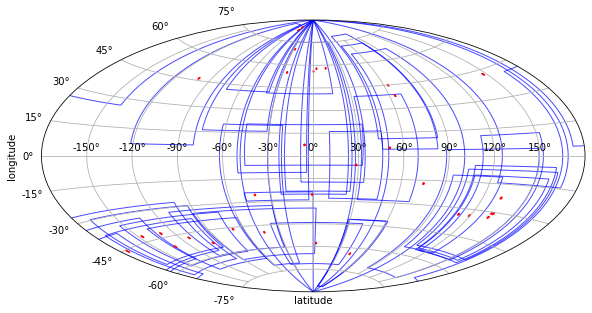

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(projection="aitoff")
ax.grid(True)

for el in products_geom_coordinates[:50]:
    ax.add_patch(patches.Polygon(el, closed=True, fc=None, ec="b", fill=False, alpha=0.7))

for cent in products_geom_centers[:50]:
    ax.add_patch(patches.Circle(cent, 0.01, color="red"))
    
    
ax.set_xlabel("latitude")
ax.set_ylabel("longitude")

Load geojson regions that we know contains areas with high crater density and overlay the dataset images patches. Use GeoPandas with inbuilt projection.

In [12]:
! ls /shared_dir

data  hackp  notebooks	start_notebook.sh


In [13]:
import geopandas as gpd
from os import listdir
from os.path import join
%matplotlib notebook
geo_regions = listdir('/shared_dir/data/geometries/')

for geo in geo_regions[0:1]:
    df = gpd.read_file(join('/shared_dir/data/geometries/', geo))
    print(df.columns)
    print(df["geometry"])

Index(['name', 'geometry'], dtype='object')
0    POLYGON ((44.46222 6.13163, 6.89939 6.13163, 6...
Name: geometry, dtype: geometry


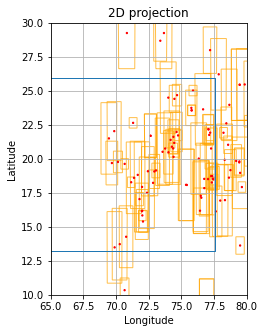

In [41]:
%matplotlib inline

fig = plt.figure(figsize=(10, 5))

#ax = plt.subplot(projection="aitoff")
ax = plt.subplot()
ax.grid(True)

ax.set_title("2D projection")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_ylim([-90, 90])
#ax.set_xlim([-180, 180])
#@ax.set_ylim([-40, 40])
#ax.set_xlim([-25, 180])

ax.set_ylim([10, 30])
ax.set_xlim([65, 80])

# blue
for geo in geo_regions:
    df = gpd.read_file(join('/shared_dir/data/geometries/', geo))
    df.boundary.plot(ax=ax, facecolor=None, linewidth=1)
        
# purple
for el in products_geom_coordinates:
    ax.add_patch(patches.Polygon(el, closed=True, facecolor=None, edgecolor="orange", fill=False, alpha=0.7))

for cent in products_geom_centers:
    ax.add_patch(patches.Circle(cent, 0.05, color="red"))
    
fig.savefig("intersections.png", dpi=300)

Create GeoDataFrames from preselected geometries containing craters and dataset geometries. This should help filtering the dataset via intersection or overlap in order to filter out areas with small craters density.

In [13]:
from shapely.geometry import Polygon

p1_list, p1_id = [], []
for geo in geo_regions:
    df = gpd.read_file(join('/shared_dir/data/geometries/', geo))
    p1_list.append([item for item in df.geometry][0])
    p1_id.append(df.name[0])
    
p1 = gpd.GeoSeries(p1_list, crs="EPSG:4326")
rois = gpd.GeoDataFrame({'geometry': p1, 'id': p1_id})

p2_list = []
for el in products_geom_coordinates:
    p2_list.append([Polygon([(item[0], item[1]) for item in el])][0])
    
p2 = gpd.GeoSeries(p2_list, crs="EPSG:4326")
imgs = gpd.GeoDataFrame({'geometry': p2, 'id': products_id})

rois.head(), imgs.head()

(                                            geometry          id
 0  POLYGON ((26.70435 -51.84561, -39.31091 -51.84...  Geometry12
 1  POLYGON ((100.36193 -12.73493, 100.36193 -5.02...   Geometry4
 2  POLYGON ((102.88793 -26.01929, 102.88793 -10.7...   Geometry5
 3  POLYGON ((-44.52324 -52.96351, -90.04818 -52.9...  Geometry13
 4  POLYGON ((-43.42005 3.06649, -43.42005 12.1230...  Geometry18,
                                             geometry  \
 0  POLYGON ((95.00976 26.90261, 95.69864 26.90261...   
 1  POLYGON ((122.98032 20.56257, 123.68478 20.562...   
 2  POLYGON ((133.49006 47.05846, 134.55690 47.058...   
 3  POLYGON ((137.38463 -6.79135, 138.17398 -6.791...   
 4  POLYGON ((-126.45577 69.00789, -125.09355 69.0...   
 
                                id  
 0  P01_001463_2077_XN_27N264W.tif  
 1  P01_001462_2017_XI_21N236W.tif  
 2  P01_001435_2280_XI_48N226W.tif  
 3  P01_001422_1747_XN_05S222W.tif  
 4  P01_001418_2494_XI_69N125W.tif  )

Intersection allows to define the areas of geometry which are contained by both sets. The issue is that it works row by row, one geometry against the other. Given that we have 20 region of interest against 905 images, the intersection ends up empy. We should find a solution that performs the intersection in each permutation of the two dataframes.

In [14]:
intersected = rois.intersection(imgs, align=True)     
intersected[~intersected.is_empty][~intersected.isna()]

/opt/venv/adamapienv/lib/python3.8/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/tmp/ipykernel_90/3069809291.py:2: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  intersected[~intersected.is_empty][~intersected.isna()]


GeoSeries([], dtype: geometry)

The same as for the intersection can be said about the <code>contains</code> method.

In [15]:
contained = rois.contains(imgs, align=True)     
contained[~contained == False]

/opt/venv/adamapienv/lib/python3.8/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


Series([], dtype: bool)

Let's try to iterate the intersection geometry-wise and save the intersection in a new GeoDataFrame with corresponding geometry IDs and centers.

In [16]:
intersected_list, intersected_ids = [], []
for geo in geo_regions:
    df = gpd.read_file(join('/shared_dir/data/geometries/', geo))
    roi = gpd.GeoSeries([item for item in df.geometry][0], crs="EPSG:4326")

    for idx, el in enumerate(products_geom_coordinates):
        img = gpd.GeoSeries([Polygon([(item[0], item[1]) for item in el])][0], crs="EPSG:4326")

        intersected = roi.intersection(img)
        if not intersected.is_empty.any():
            intersected_list.append(intersected[0])
            intersected_ids.append(products_id[idx])

intersected_series = gpd.GeoSeries(intersected_list, crs="EPSG:4326")
intersected_df = gpd.GeoDataFrame({'geometry': intersected_series, 
                                   'id': intersected_ids,
                                   'center': intersected_series.centroid,
                                   'area': intersected_series.area,
                                   'length': intersected_series.length,
                                   'sqeql': np.sqrt(intersected_series.area)
                                  })
            
intersected_df.head()

/tmp/ipykernel_90/3090448484.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'center': intersected_series.centroid,
/tmp/ipykernel_90/3090448484.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'area': intersected_series.area,
/tmp/ipykernel_90/3090448484.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'length': intersected_series.length,
/tmp/ipykernel_90/3090448484.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'sqeql': 

,geometry,id,center,area,length,sqeql
0,"POLYGON ((-5.21951 -2.13335, -5.21938 -2.41520...",P01_001414_1780_XI_02S005W.tif,POINT (-5.50345 -2.27428),0.160092,1.699720,0.400115
1,"POLYGON ((-5.23724 -2.13335, -5.23711 -2.41368...",P01_001612_1780_XI_02S005W.tif,POINT (-5.50306 -2.27352),0.149068,1.624182,0.386093
2,"POLYGON ((-6.64749 -2.13335, -6.64666 -4.98130...",P03_002377_1774_XI_02S007W.tif,POINT (-7.15202 -3.55788),2.876132,7.715688,1.695916
3,"POLYGON ((-5.32652 -2.13335, -5.32533 -4.80922...",P06_003511_1779_XI_02S005W.tif,POINT (-5.88062 -3.47168),2.968576,7.570512,1.722956
4,"POLYGON ((-4.08334 -2.13335, -4.07984 -5.93348...",P06_003445_1768_XI_03S004W.tif,POINT (-4.62565 -4.03462),4.135013,9.776502,2.033473


Plot the intersections between geometries and dataset.

<IPython.core.display.Javascript object>


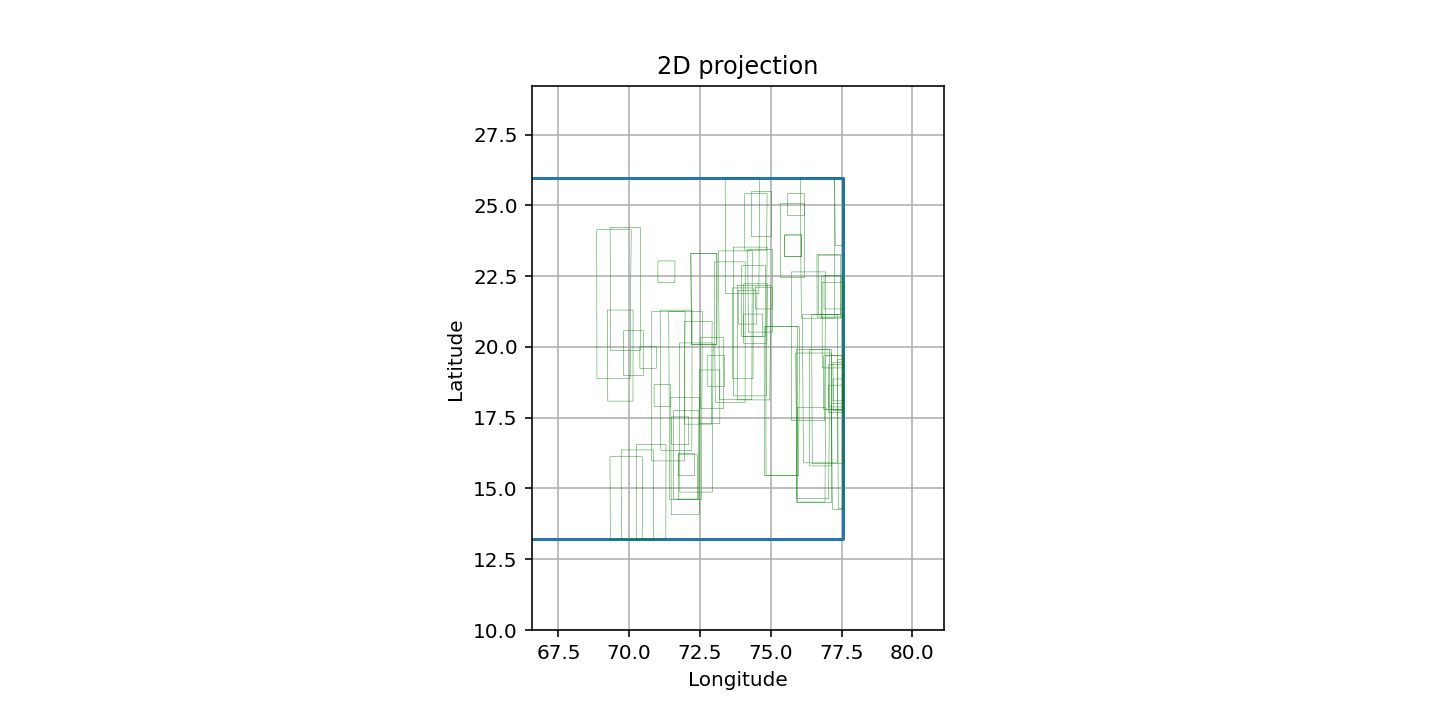

<AxesSubplot:title={'center':'2D projection'}, xlabel='Longitude', ylabel='Latitude'>

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax.grid(True)

ax.set_title("2D projection")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_ylim([-90, 90])
ax.set_xlim([-180, 180])

# blue
for geo in geo_regions:
    df = gpd.read_file(join('/shared_dir/data/geometries/', geo))
    df.boundary.plot(ax=ax, fc=None)
        
# purple
intersected_df.boundary.plot(ax=ax, fc=None, ec='g', lw=0.2)

Length of intersected dataset:

In [18]:
len(intersected_df)

264

Find average square equivalent length for the intersected dataset.

In [19]:
intersected_df['sqeql'].mean()

1.1482808587021105

Now let's order the geometries in the GeoDataFrame by their global location. We do so by computing the x- and y-coordinates of the centroids of each geometry. To do so we need to reduce from 2d to 1d, thus we average the x- and y-coordinates and then sort the geometries by this averaged value.

In [23]:
sorted_intersected_df = (intersected_df
                         .assign(x=lambda df: df['center'].x)
                         .assign(y=lambda df: df['center'].y)
                         .assign(aval=lambda df: df[['x', 'y']].mean(axis=1))
                         .sort_values(by=['aval']))

len(sorted_intersected_df)

264

In [24]:
sorted_intersected_df.head()

,geometry,id,center,area,length,sqeql,x,y,aval
63,"POLYGON ((-18.25590 -26.02282, -18.25238 -26.6...",D01_027787_1558_XI_24S018W.tif,POINT (-18.25473 -26.43525),0.001089,1.240838,0.033002,-18.254728,-26.435251,-22.344989
67,"POLYGON ((-18.25590 -21.34536, -18.24486 -21.3...",D04_028697_1558_XI_24S018W.tif,POINT (-18.24082 -24.53451),0.143945,10.709774,0.379401,-18.240817,-24.534509,-21.387663
9,"POLYGON ((-7.26711 -2.29212, -6.19083 -2.29212...",P14_006557_1750_XN_05S006W.tif,POINT (-6.72788 -4.94455),5.724793,12.756788,2.392654,-6.727878,-4.944552,-5.836215
39,"POLYGON ((-6.90802 -2.40305, -6.09076 -2.40305...",B11_013743_1752_XN_04S006W.tif,POINT (-6.50113 -4.78824),3.907712,11.169928,1.976793,-6.501135,-4.788240,-5.644687
13,"POLYGON ((-6.75724 -2.26387, -5.67701 -2.26387...",P15_007058_1751_XI_04S006W.tif,POINT (-6.21799 -4.91306),5.738657,12.751824,2.395549,-6.217992,-4.913057,-5.565525


Indexes are now not ordered as well as not contiguous. Let's reindex all the surviving rows.

In [25]:
sorted_intersected_df = sorted_intersected_df.reset_index(drop=True)
sorted_intersected_df.head()

,geometry,id,center,area,length,sqeql,x,y,aval
0,"POLYGON ((-18.25590 -26.02282, -18.25238 -26.6...",D01_027787_1558_XI_24S018W.tif,POINT (-18.25473 -26.43525),0.001089,1.240838,0.033002,-18.254728,-26.435251,-22.344989
1,"POLYGON ((-18.25590 -21.34536, -18.24486 -21.3...",D04_028697_1558_XI_24S018W.tif,POINT (-18.24082 -24.53451),0.143945,10.709774,0.379401,-18.240817,-24.534509,-21.387663
2,"POLYGON ((-7.26711 -2.29212, -6.19083 -2.29212...",P14_006557_1750_XN_05S006W.tif,POINT (-6.72788 -4.94455),5.724793,12.756788,2.392654,-6.727878,-4.944552,-5.836215
3,"POLYGON ((-6.90802 -2.40305, -6.09076 -2.40305...",B11_013743_1752_XN_04S006W.tif,POINT (-6.50113 -4.78824),3.907712,11.169928,1.976793,-6.501135,-4.788240,-5.644687
4,"POLYGON ((-6.75724 -2.26387, -5.67701 -2.26387...",P15_007058_1751_XI_04S006W.tif,POINT (-6.21799 -4.91306),5.738657,12.751824,2.395549,-6.217992,-4.913057,-5.565525


In order to avoid excessive overlap in the dataset, we filter out images that are consider not distinct. In this algorithm, we define two distinct images as having the centroid of their geometry that has vectorial distance greater than half of the mean square equivalent length of the dataset itself. If two images are found to be not distinct we drop keep the first (lower located) image and compare to the following. This way, having an ordered dataset, we can maximise the number of distinct images comprised in a cluster.

In [26]:
meanl = intersected_df['sqeql'].mean()
filtered_intersected_df = sorted_intersected_df

idx = 0
while idx < len(filtered_intersected_df)-1:
    current = filtered_intersected_df.loc[idx,:]['geometry']
    nextone = filtered_intersected_df.loc[idx+1,:]['geometry']
    centers_distance = current.distance(nextone)
    if centers_distance >= meanl/4:
        idx += 1        
    else:
        filtered_intersected_df = filtered_intersected_df.drop(idx+1).reset_index(drop=True)
        
len(sorted_intersected_df), len(filtered_intersected_df)       

(264, 56)

In [27]:
filtered_intersected_df['id']

0     D01_027787_1558_XI_24S018W.tif
1     P14_006557_1750_XN_05S006W.tif
2     D06_029738_1759_XN_04S004W.tif
3     D07_029804_1770_XN_03S006W.tif
4     G11_022670_1761_XN_03S005W.tif
5     G23_027193_1786_XN_01S006W.tif
6     F10_039839_1762_XI_03S004W.tif
7     F10_039760_1777_XN_02S006W.tif
8     P22_009497_1768_XI_03S005W.tif
9     F01_036186_1762_XI_03S004W.tif
10    P11_005423_1795_XI_00S005W.tif
11    P13_006119_1936_XN_13N290W.tif
12    P05_003152_1956_XI_15N287W.tif
13    P17_007767_1972_XN_17N288W.tif
14    P15_006831_1998_XN_19N290W.tif
15    P09_004352_1985_XI_18N288W.tif
16    P14_006554_1976_XN_17N287W.tif
17    P04_002651_1999_XI_19N289W.tif
18    P16_007411_1981_XN_18N288W.tif
19    P01_001332_1997_XI_19N289W.tif
20    P06_003429_2017_XI_21N290W.tif
21    P04_002730_1984_XI_18N287W.tif
22    P17_007622_2022_XN_22N290W.tif
23    P06_003508_1992_XI_19N287W.tif
24    P12_005644_1964_XI_16N283W.tif
25    P18_007912_2028_XN_22N288W.tif
26    P17_007846_2007_XN_20N286W.tif
2